# SocialAL Models
# Data simulation and parameter recovery - multiple subjects
KLS 8.30.19; update 1.27.22  
Project info: https://osf.io/b48n2/

Model modified from :
Fareri, D. S., Chang, L. J., & Delgado, M. R. (2012). Effects of direct social experience on trust decisions and neural reward circuitry. Frontiers in Neuroscience, 6, 1–17. https://doi.org/10.3389/fnins.2012.00148

### Python version

In [1]:
import sys
print(sys.version)  

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Load modules

In [2]:
import numpy as np
import random
import math
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Define functions (from model development notebook)

In [3]:
def update_value(Prob, EV, choice, response):
    invest = [0,3,6,9]
    retain = [9-x for x in invest] #print ("Retain list is: ", retain)
    shared = [2*x for x in invest] #print ("Shared list is: ", shared)
    EV[choice-1] = retain[choice-1] + Prob*shared[choice-1]
    return EV

def get_action_selection_prob(beta, EV, choice):
    numerator = np.exp(beta*EV[choice-1])
    denominator = np.sum([np.exp(beta*x) for x in EV])
    actionProb = numerator/denominator
    return actionProb

def get_action_selection_probs(beta, EV):
    actionProbs = [get_action_selection_prob(beta, EV, x) for x in range(1,5)]
    return actionProbs

def action_selection(actionProb):
    cumprob = np.cumsum(actionProb) # cumulative probability 
    num = random.uniform(0,1) # pick a random number between 0 and 1, see where it falls
    if num < cumprob[0]: action = 1
    elif num < cumprob[1]: action = 2
    elif num < cumprob[2]: action = 3
    else: action = 4   
    return action

In [4]:
#def update_prob (recip, Prob, a_gain, a_loss):
#    gain = max(recip - Prob, 0)
#    loss = min(recip - Prob, 0)
#    Prob = Prob + a_gain * gain + a_loss * loss
#    return Prob

def update_prob(recip, Prob, alpha):
    Prob = Prob + alpha*(recip-Prob)
    return Prob

In [5]:
def select_response(prob):     
    n = random.uniform(0,1)
    if n > prob:
        response = 0
    else:
        response = 1
    return response

### Set constants

In [6]:
recip_rates = {0: 0.93, 1:0.6, 2:0.07}

### New function to simulate data for one sub

In [12]:
def sim_data(tn, params):
    # tn: number of trials desired
    # params: ground truth of parameters
    #a_gain = params[0]
    #a_loss = params[1]
    #beta = params[2]
    
    alpha = params[0]
    beta = params[1]

    
    # initialize variables
    Probs = [0.5, 0.5, 0.5]
    EVs = [[9,9,9,9],[9,9,9,9],[9,9,9,9]]
    
    # generate trial sequence
    trial_sequence = np.repeat([0,1,2], tn)
    random.shuffle(trial_sequence) #print(trial_sequence)
    
    choices = []
    responses = []
    
    for x in range(0,len(trial_sequence)):
        t = trial_sequence[x] 
        
        # Make a choice
        choice = action_selection(get_action_selection_probs(beta, EVs[t]))
        choices.append(choice) 
    
        # Get a response
        recip_rate = recip_rates.get(t) 
        
        response = select_response(recip_rate) 
        responses.append(response)
    
        # after choice, update probability
        if choice != 1:
            #Probs[t] = update_prob(response, Probs[t], a_gain, a_loss) 
            Probs[t] = update_prob(response, Probs[t], alpha)
        # then update value
        EVs[t] = update_value(Probs[t], EVs[t], choice, response) 
        
    data = {'Stim_Sequence': trial_sequence, 'Choice' : choices, 'Trustee_Response': responses}    
    return data

### New function to calculate likelihood

In [8]:
def get_likelihood_action(params, data):
    #a_gain = params[0]
    #a_loss = params[1]
    #beta = params[2]
    
    alpha = params[0]
    beta = params[1]
    
    # initialize variables
    prob = [0.5, 0.5, 0.5]
    ev = [[9,9,9,9],[9,9,9,9],[9,9,9,9]]
    
    totalLLH = math.inf
    for trial in range(0, len(data)):
        trustee = data['Stim_Sequence'][trial] # get trustee type
        choice = data['Choice'][trial] # get choice made by participant
        response = data['Trustee_Response'][trial] # get response from trustee
        
        # compute the probability of selecting each option for that trustee
        probs = get_action_selection_probs(beta, ev[trustee])
        
        if choice != 0:
            # use the probability of the selection (choice-probability) to update log likelihood
            cprob = probs[choice-1]

            #add to cumulative log likelihood
            totalLLH += -math.log(cprob)

            # update prob and value
            if choice != 1:
                #prob[trustee] = update_prob(response, prob[trustee], a_gain, a_loss)
                prob[trustee] = update_prob(response, prob[trustee], alpha)
            ev[trustee] = update_value(prob[trustee], ev[trustee], choice, response)
        
    return totalLLH

### New function to fit model

In [59]:
def model_fit(data):
    
    # initialize free parameters with randomly chosen numbers
    #a_gain=random.uniform(0, 1)
    #a_loss=random.uniform(0, 1)
    #beta=random.uniform(0, 1)
    #params = [a_gain, a_loss, beta]
    
    alpha=random.uniform(0, 1)
    beta=random.uniform(0, 20)
    params = [alpha, beta]
    
    results = minimize(get_likelihood_action, params, args =(data), options = {'maxiter': 10000, 'disp': False})
    return results.x
    

### New function to sim data for multiple subjects

In [60]:
def sim_mult_subject_data(n, tn, params):
    data = pd.DataFrame(columns= ['Stim_Sequence', 'Choice', 'Trustee_Response', 'Subject'])
    for x in range(1, n+1):
        sdt = sim_data(tn, params)
        sdt = pd.DataFrame.from_dict(sdt)
        sdt['Subject'] = [x for t in range(0,tn*3)]
        data = pd.concat([data,sdt])
    return data

In [120]:
dt = sim_mult_subject_data(10,10000,[0.2,2])

### New function to fit model to multiple subjects

In [121]:
def model_fit_mult_subject(data):
    #pdt = pd.DataFrame(columns = ['Subject', 'a_gain', 'a_loss', 'beta'])
    pdt = pd.DataFrame(columns = ['Subject', 'alpha', 'beta'])
    a = pd.unique(data['Subject'])
    for x in range(1,len(a)+1):
        df = data[data['Subject']==x]
        dt = df.to_dict()
        params = model_fit(dt)
        #line = {'Subject': x, 'a_gain': params[0], 'a_loss': params[1], 'beta':params[2]}
        line = {'Subject': x, 'alpha': params[0], 'beta': params[1]}
        pdt = pdt.append(line, ignore_index=True)   
    return(pdt)


In [122]:
precover = model_fit_mult_subject(dt)

In [123]:
print(precover)

   Subject     alpha       beta
0      1.0  0.257429   9.385076
1      2.0  0.892383  13.449729
2      3.0  0.476948  13.676879
3      4.0  0.249762  15.107343
4      5.0  0.666569  13.028245
5      6.0  0.365021   4.902200
6      7.0  0.765481  18.196436
7      8.0  0.481832   5.227139
8      9.0  0.793996  19.939247
9     10.0  0.996950  16.879143


In [124]:
#print(precover['alpha'])

Text(0, 0.5, 'Counts')

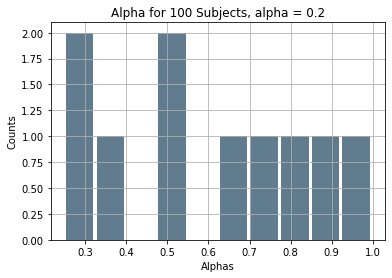

In [125]:
alpha = pd.Series(precover['alpha'])
#print(alpha)
alpha.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Alpha for 100 Subjects, alpha = 0.2')
plt.xlabel('Alphas')
plt.ylabel('Counts')
#plt.grid(axis=precover['a_gain'], alpha=0.75)

In [126]:
#print(precover['a_loss'])

In [127]:
#loss = pd.Series(precover['a_loss'])
#print(loss)
#loss.plot.hist(grid=True, bins=10, rwidth=0.9,
#                   color='#607c8e')
#plt.title('Alpha Loss for 100 Subjects, alpha = 0.2')
#plt.xlabel('Alphas')
#plt.ylabel('Counts')
#plt.grid(axis=precover['a_loss'], alpha=0.75)

In [128]:
#print(precover['beta'])

Text(0, 0.5, 'Counts')

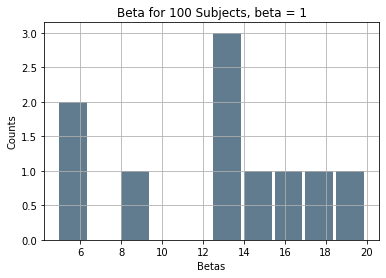

In [129]:
beta = pd.Series(precover['beta'])
#print(beta)
beta.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Beta for 100 Subjects, beta = 1')
plt.xlabel('Betas')
plt.ylabel('Counts')
#plt.grid(axis=precover['beta'], beta=0.75)